In [23]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.morphology
import skimage.filters
import skimage.segmentation
import skimage.measure
from skimage.color import label2rgb
import glob
from typing import List

In [24]:
def open_image(filename: str):
    img = Image.open(filename).convert("L")
    img.thumbnail((960, 1280))
    return np.array(img).reshape(img.size[1], img.size[0])

def show(img: np.ndarray, title: str, verbose: bool = False):
    if verbose:
        plt.figure()
        plt.title(title)
        plt.imshow(img, cmap="gray")
        plt.show()

def extract_background_mask(initial_image: np.ndarray, verbose: bool = False):
    image: np.ndarray = initial_image.copy()

    show(image, "input image", verbose)

    # extract edges
    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY, 33, 2)
    show(image, "adaptive threshold", verbose)

    # remove noise
    image = skimage.morphology.binary_dilation(image, np.ones((3, 3)))
    show(image, "binary dilation to remove noise", verbose)

    # close edges
    image = 1 - skimage.morphology.binary_closing(1 - image, np.ones((10, 10)))
    show(image, "binary closing of edges", verbose)

    # thicken edges
    image = 1 - skimage.morphology.binary_dilation(1 - image, np.ones((10, 10)))
    show(image, "binary erosion to thicken edges", verbose)

    # blur
    image = (skimage.filters.gaussian(image.astype("float"),
                                      sigma=15) * 255).astype("uint8")
    show(image, "gaussian", verbose)

    # chan-vese
    image = skimage.segmentation.morphological_chan_vese(image, iterations=30)
    show(image, "morphological chan_vese", verbose)

    # extract largest component
    labels = skimage.measure.label(image, 2)
    largestCC = labels == np.argmax(np.bincount(labels.flat))
    image = largestCC.astype("int")
    show(image, "largest connected component", verbose)

    # dilate background
    image = skimage.morphology.binary_dilation(image, np.ones((20, 20)))
    show(image, "binary dilation to compensate for gauss and chan-vese", verbose)

    return image

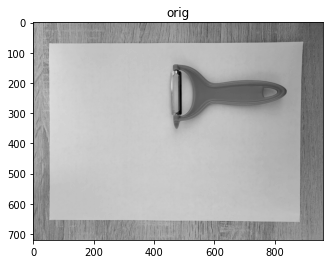

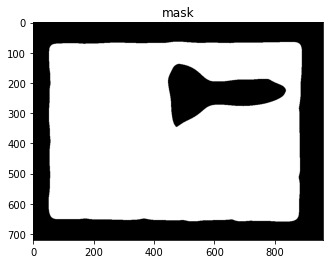

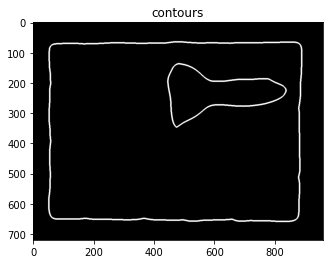

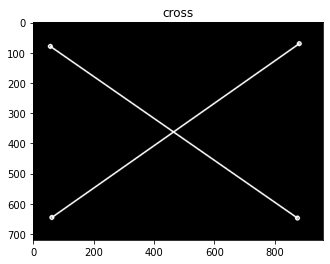

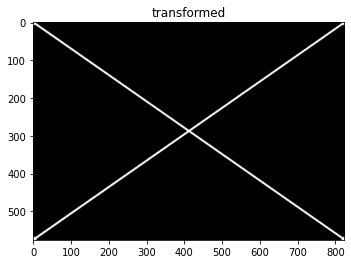

Matrix =  [[ 1.01762004e+00 -9.00548710e-03 -5.72839034e+01]
 [ 1.09616765e-02  1.00360238e+00 -8.09130060e+01]
 [ 2.34155042e-05 -2.35783192e-05  1.00000000e+00]]
mm in 1 pixel =  0.3625101132686084


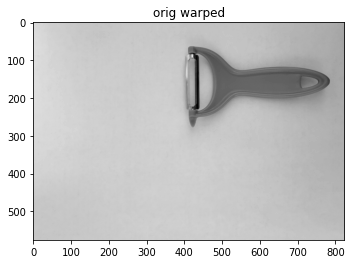

In [32]:
def get_perspective_matrix_and_scale(a4mask, verbose: bool = False):
    def order_points(pts):
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    def four_point_transform(image, pts):
        rect = order_points(pts)
        (tl, tr, br, bl) = rect
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
        maxWidth = max(int(widthA), int(widthB))
        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        maxHeight = max(int(heightA), int(heightB))
        dst = np.array([
            [0, 0],
            [maxWidth - 1, 0],
            [maxWidth - 1, maxHeight - 1],
            [0, maxHeight - 1]], dtype="float32")
        M = cv2.getPerspectiveTransform(rect, dst)
        wk = 297.0 / max(maxWidth, maxHeight)
        hk = 210.0 / min(maxWidth, maxHeight)
        k = (hk + wk) / 2
        warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
        show(warped, "transformed", verbose)
        return M, k, maxWidth, maxHeight

    contours, hierarchy = cv2.findContours(a4mask.astype("uint8"), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    img = np.zeros(a4mask.shape, "uint8")
    cv2.drawContours(img, contours, -1, (1,0,0), 3)
    show(img, "contours", verbose)

    perimeter = cv2.arcLength(contours[0], True)
    approx = cv2.approxPolyDP(contours[0], 0.05 * perimeter, True)
    # test
    img = np.zeros(a4mask.shape, "uint8")
    for point in approx:
        x, y = point[0]
        cv2.circle(img, (x, y), 6, (255, 255, 0), 4)
    pts = np.array([approx[0][0], approx[1][0], approx[2][0], approx[3][0]], dtype="float32")
    ordered = order_points(pts)
    (tl, tr, br, bl) = ordered
    cv2.line(img, (tl[0].astype("int"), tl[1].astype("int")), (br[0].astype("int"), br[1].astype("int")),
             (255, 255, 0), thickness=3)
    cv2.line(img, (tr[0].astype("int"), tr[1].astype("int")), (bl[0].astype("int"), bl[1].astype("int")),
             (255, 255, 0), thickness=3)
    show(img, "cross", verbose)
    # end test
    M, k, w, h = four_point_transform(img, pts)
    print("Matrix = ", M)
    print("mm in 1 pixel = ", k)
    return M, k, w, h

image = open_image("test.jpg")
show(image, "orig", True)
background = extract_background_mask(image, False)
show(background, "mask", True)
m, k, w, h = get_perspective_matrix_and_scale(background, True)
warp = cv2.warpPerspective(image, m, (w, h))
show(warp, "orig warped", True)